In [1]:
import sys, os
from pathlib import Path
ROOT = Path.cwd().parent
if str(ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(ROOT / 'src'))
print('Added to sys.path:', ROOT / 'src')


Added to sys.path: /home/spina/Desktop/units/DL/project/final_repo/src


In [2]:

import os, sys, math, json
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path


sys.path.append('')


from src.mouse_transforms import mouse_transform

from src.mouse_transforms import UnNormalize
from src.mouse_csf import load_or_fit_params
from src.plot_utils import *

IMAGE_PATH = ROOT/'allen-data-clean/stimuli_images/stimulus_71.png'
# IMAGE_PATH = ROOT / 'assets/dog.JPEG'  
CSF_JSON = ROOT / 'artifacts/csf/mouse_csf_params.json'
os.makedirs(os.path.dirname(CSF_JSON), exist_ok=True)


import random, numpy as np, torch
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


CSF_FIT = False

IMG_SIZE = 224

In [3]:
blur_sig, blur_ker, noise_std, patch_size = load_or_fit_params(CSF_JSON, force_fit=CSF_FIT, pca_n=32)
print(f'CSF params: blur_sigma={blur_sig:.3f}, blur_ker={blur_ker}, noise_std={noise_std:.3f}, patch_size={patch_size}')

Loading cached CSF params from /home/spina/Desktop/units/DL/project/final_repo/artifacts/csf/mouse_csf_params.json
CSF params: blur_sigma=1.760, blur_ker=11, noise_std=0.250, patch_size=24


In [4]:
noise_rng = torch.Generator().manual_seed(1)

tfm = mouse_transform(
    img_size=224,
    blur_sig=blur_sig,
    noise_std=noise_std,
    normalize='imagenet',
    noise_rng=noise_rng,
    to_gray=True,
    train=False,
    gray_keep_channels=True,
)

unnorm = UnNormalize('imagenet')

In [5]:
assert os.path.isfile(IMAGE_PATH), f'Image not found: {IMAGE_PATH}'

# The pipeline returns a dict after the affine step; extract the tensor
def _get_img_t(out):
    if isinstance(out, dict):
        img_t = out['imgs']
        affine_params = out.get('affine', None)  # (angle, translations, scale, shear)
    else:
        img_t = out
        affine_params = None
    disp = unnorm(out if isinstance(out, dict) else img_t)
    disp_t = disp['imgs'] if isinstance(disp, dict) else disp
    disp_t = disp_t.detach().cpu().clamp(0, 1)
    disp_t = disp_t[0] if disp_t.dim() == 4 else disp_t
    disp_np = disp_t.permute(1, 2, 0).numpy()
    return disp_np, affine_params

In [6]:
img_pil = Image.open(IMAGE_PATH).convert('RGB')

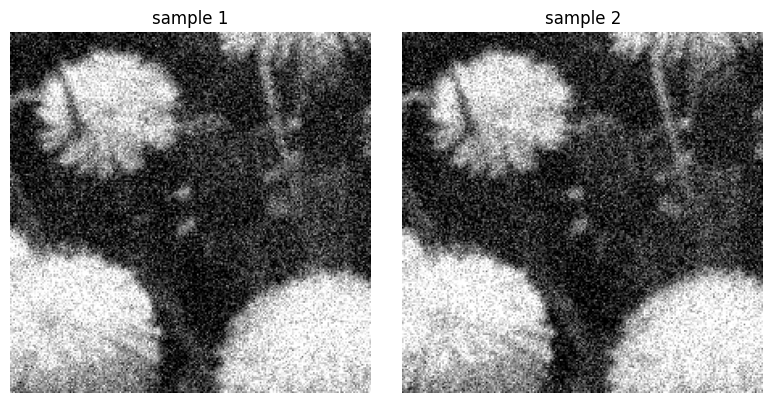

In [7]:
from src.plot_utils import plot_image_pair

plot_image_pair(_get_img_t(tfm(img_pil))[0], _get_img_t(tfm(img_pil))[0], title_left='sample 1', title_right='sample 2')
pass

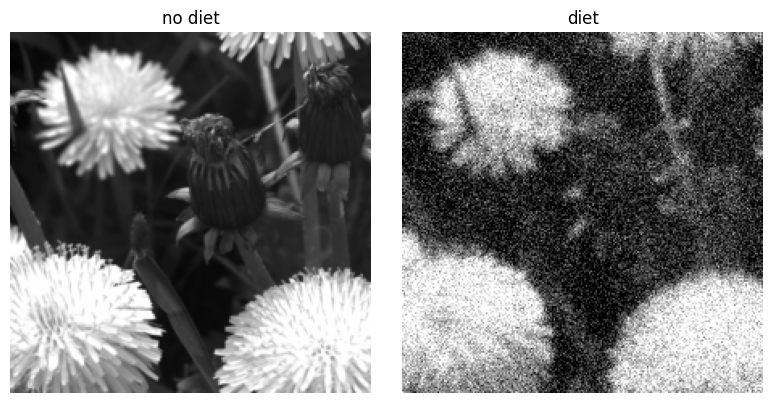

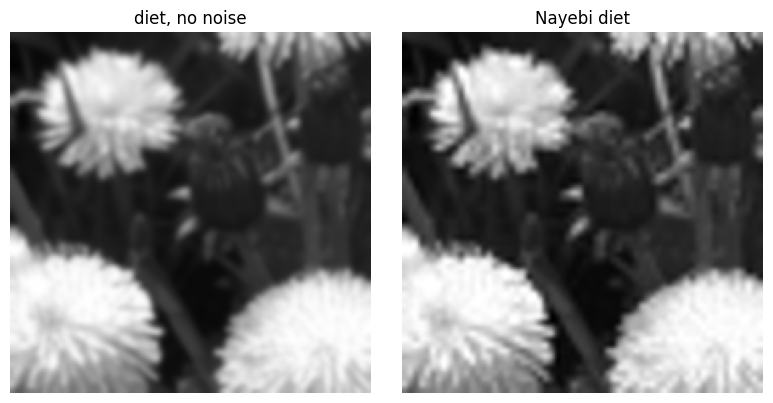

In [8]:
# Nayebi diet

import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

nayebi_diet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Resize(64, interpolation=InterpolationMode.BICUBIC, antialias=True),  # downsample (blur)
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),                 # upsample (sfocatura)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

stimuli_71 = Image.open(IMAGE_PATH).convert('RGB')


noise_rng = torch.Generator().manual_seed(1)

no_diet = mouse_transform(
    img_size=224,
    blur_sig=0,
    noise_std=0,
    normalize='imagenet',
    noise_rng=noise_rng,
    to_gray=True,
    train=False,
    gray_keep_channels=True,
)

diet_no_noise = mouse_transform(
    img_size=224,
    blur_sig=blur_sig,
    noise_std=0,
    normalize='imagenet',
    noise_rng=noise_rng,
    to_gray=True,
    train=False,
    gray_keep_channels=True,
)

unnorm = UnNormalize('imagenet')

plot_image_pair(_get_img_t(no_diet(stimuli_71))[0], _get_img_t(tfm(stimuli_71))[0], title_left='no diet', title_right='diet')
pass

plot_image_pair(_get_img_t(diet_no_noise(stimuli_71))[0], _get_img_t(nayebi_diet(stimuli_71))[0], title_left='diet, no noise', title_right='Nayebi diet')
pass

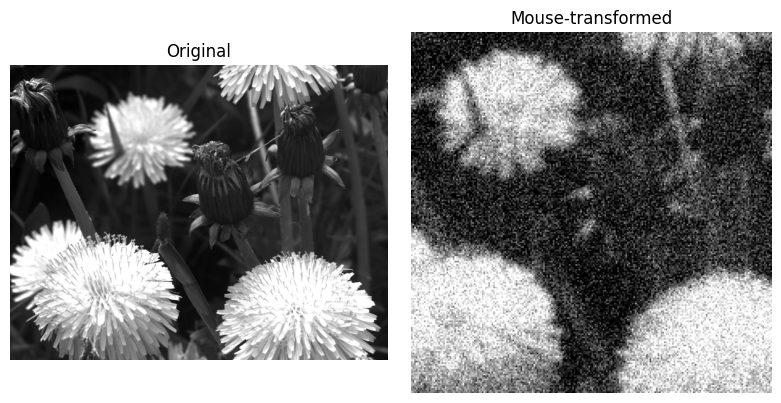

In [9]:
disp_np, _ = _get_img_t(tfm(img_pil))
plot_image_pair(img_pil, disp_np, title_left='Original', title_right='Mouse-transformed')
pass

Loaded CSF results from mouse_csf_results.pkl


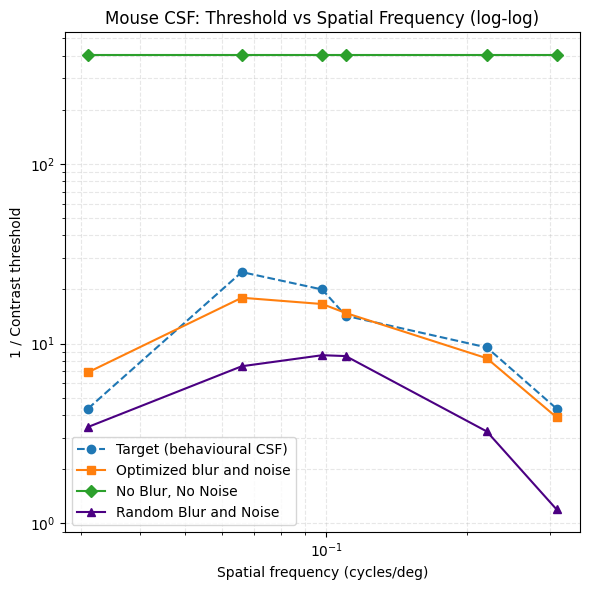

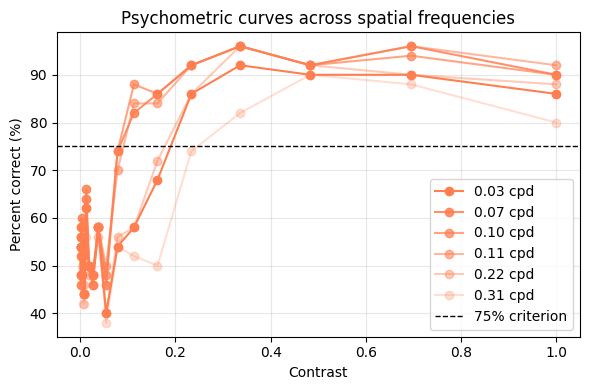

In [10]:
# Cell — Compute or load CSF results and save to pickle

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from src.mouse_params import MOUSE_CSF_TARGET, CONTRAST_SWEEP, THRESH_CRITERION
from src.mouse_csf import _simulate_detection, _estimate_threshold
import src.mouse_csf as mouse_csf  

mouse_csf.N_SAMPLES_PER_CLASS = 5000  

SIM_IMG_SIZE = 224
size = (SIM_IMG_SIZE, SIM_IMG_SIZE)

SF_LIST = sorted(MOUSE_CSF_TARGET.keys())

results_path = "mouse_csf_results.pkl"

if os.path.exists(results_path):
    with open(results_path, "rb") as f:
        res = pickle.load(f)
    curves = res["curves"]
    thresholds = res["thresholds"]
    baseline_curves = res["baseline_curves"]
    baseline_thresholds = res["baseline_thresholds"]
    random_curves = res["random_curves"]
    random_thresholds = res["random_thresholds"]
    print(f"Loaded CSF results from {results_path}")
else:
    curves = {}         # sf -> (contrasts, acc)
    thresholds = {}     # sf -> threshold
    baseline_curves = {}
    baseline_thresholds = {}
    random_curves = {}
    random_thresholds = {}

    for sf in SF_LIST:
        # This pipeline
        contrasts, acc = _simulate_detection(
            size, sf, blur_sig, blur_ker, noise_std,
            CONTRAST_SWEEP,
            patch_size=patch_size,
            seed=112, deterministic=True,
        )

        thr = _estimate_threshold(contrasts, acc, THRESH_CRITERION)
        curves[sf] = (contrasts, acc)
        thresholds[sf] = thr

        # Baseline
        baseline_contrasts, baseline_acc = _simulate_detection(
            size, sf, 0, 0, 0,
            CONTRAST_SWEEP,
            patch_size=patch_size,
            seed=112, deterministic=True,
        )

        baseline_thr = _estimate_threshold(baseline_contrasts, baseline_acc, THRESH_CRITERION)
        baseline_curves[sf] = (baseline_contrasts, baseline_acc)
        baseline_thresholds[sf] = baseline_thr

        curves_list = []
        thr_list = []

        for i in range(5):
            # Random
            random_blur_sig = np.random.uniform(1.0, 5) 
            # Dimensione del kernel: deve essere un intero dispari
            random_blur_ker = random.choice(range(5, 35, 2)) 
            # Deviazione standard del rumore
            random_noise_std = np.random.uniform(0.1, 0.5)
            
            random_contrasts, random_acc = _simulate_detection(
                size, sf, random_blur_sig, random_blur_ker, random_noise_std,
                CONTRAST_SWEEP,
                patch_size=patch_size,
                seed=112, deterministic=True,
            )
            
            random_thr = _estimate_threshold(random_contrasts, random_acc, THRESH_CRITERION)
            curves_list.append((random_contrasts, random_acc))
            thr_list.append(random_thr)

        # np.mean(curves_list, axis=0) expects array shapes, so let's just use the first element for curves for summary
        random_thresholds[sf] = np.mean(thr_list)
        random_curves[sf] = curves_list[0]  # Just save one for plotting. Change if needed.

    with open(results_path, "wb") as f:
        pickle.dump(
            dict(
                curves=curves,
                thresholds=thresholds,
                baseline_curves=baseline_curves,
                baseline_thresholds=baseline_thresholds,
                random_curves=random_curves,
                random_thresholds=random_thresholds,
            ),
            f
        )
    print(f"Saved CSF results to {results_path}")

from src.plot_utils import plot_csf_thresholds, plot_psychometric_curves, get_model_color

curves_to_plot = {
    'Optimized blur and noise': [thresholds, get_model_color("Optimized")],
    'No Blur, No Noise': [baseline_thresholds, get_model_color("No_Diet")],
    'Random Blur and Noise': [random_thresholds, get_model_color("Random")]
}
plot_csf_thresholds(SF_LIST, curves_to_plot, MOUSE_CSF_TARGET)

# Psychometric curves
SFS_TO_PLOT = list(curves.keys())
plot_psychometric_curves(curves, SFS_TO_PLOT, threshold_criterion=THRESH_CRITERION)

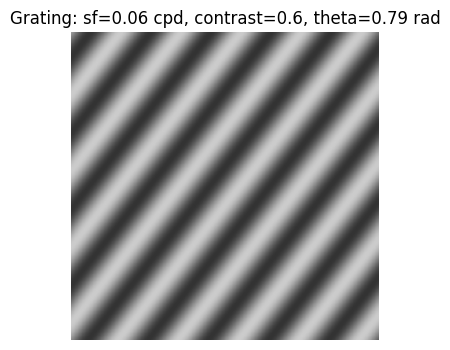

In [11]:
# Example grating using _make_grating
import sys, math
import torch
import matplotlib.pyplot as plt

# Ensure project src is importable
sys.path.append('/home/gamerio/Documents/dl/mice-representation/src')

from src.mouse_csf import _make_grating  # private helper used by CSF code

# Parameters
img_size = 224

sf_cpd   = 0.06
     # spatial frequency (cycles/deg), e.g., 0.06, 0.16, 0.33
contrast = 0.6      # Michelson contrast in [0,1]
phase    = 0.0      # radians
theta    = math.pi/4  # orientation in radians (e.g., 0, pi/4, pi/2)

# Generate and display
g = _make_grating((img_size, img_size), sf_cpd, contrast, phase, theta)  # HxW tensor in [0,1]
from src.plot_utils import plot_grating
plot_grating(g, title=f'Grating: sf={sf_cpd} cpd, contrast={contrast}, theta={theta:.2f} rad')